In [1]:
%load_ext autoreload

%autoreload 2

import os
from glob import glob
import subprocess
import shutil
import traceback
import random
import pickle
from os.path import join

import joblib
from concurrent.futures import ProcessPoolExecutor

from backports import tempfile

import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144
matplotlib.rcParams["image.composite_image"]=False
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from numpy.fft import rfft, irfft, fft, ifft

import psrchive
import residuals

import pipe
from pipe import rotate_phase, convert_template, align_profile, align_scale_profile

plt.viridis()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


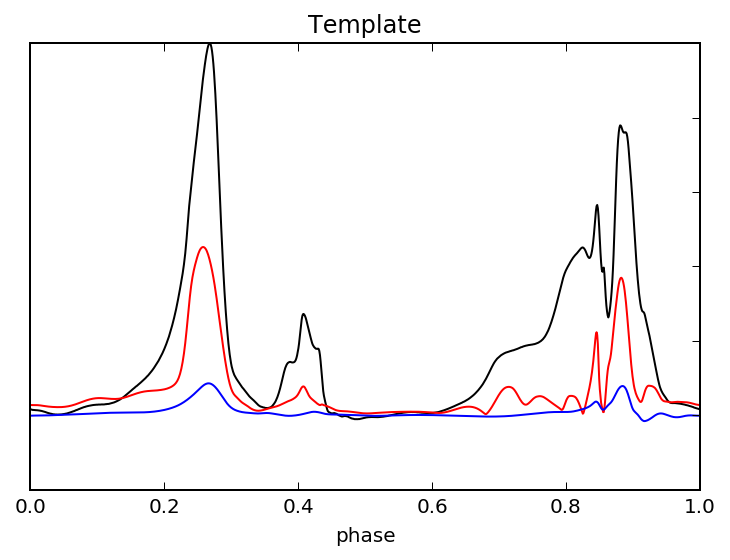

In [2]:
template = "template-work/56412.76_GBT_1400.rmset.scrunch.sm"
T = psrchive.Archive_load(template)
T.convert_state('Stokes')
T.dedisperse()
T.remove_baseline()
t_values = T.get_data()[0,0,0,:]
t_pol = T.get_data()[0,:,0,:]
t_pol /= np.amax(t_values)
t_values /= np.amax(t_values)
# shift fundamental to zero phase
a = np.angle(np.fft.fft(t_values)[1])/(2*np.pi)
t_values = pipe.rotate_phase(t_values, -a) 
t_pol = np.array([pipe.rotate_phase(p, -a) for p in t_pol])
t_phases = np.linspace(0,1,len(t_values),endpoint=False)
plt.plot(t_phases,t_pol[0],color='k')
plt.plot(t_phases,np.hypot(t_pol[1],t_pol[2]),color='r')
plt.plot(t_phases,t_pol[3],color='b')
plt.title("Template")
plt.xlabel("phase")
plt.gca().tick_params("y", left="off", labelleft="off")

In [3]:
observation = "data/obs/57400.02_AO_1400"
processing_name = "singlefrequency"

scrunches = glob(join(observation,processing_name,"scrunch_*.ar"))
scrunch = scrunches[0]

In [5]:
P = subprocess.Popen(["pat", "-s", template, "-p", "-v", "-f", "tempo2 ipta", scrunch],
                    stdout=subprocess.PIPE, stderr=subprocess.PIPE)
output, error = P.communicate()
if P.returncode:
    raise ValueError("pat failed with error code %d\noutput:\n%s\nerror:\n%s" % (P.returncode, output, error))

In [6]:
print output

FORMAT 1



In [7]:
print error

pat: using full polarization
FITSArchive::interpret_pol_type WARNING unknown POL_TYPE='IQUV'
FITSArchive::interpret_pol_type WARNING guessing state from NPOL=4
Pulsar::Integration ctor this=0xb2cad0
Pulsar::Integration::add_extension appending
Pulsar::Integration::add_extension appending
Integration::resize npol=4 nchan=1 nbin=1024
 old npol=0 nchan=0 nbin=0
Pulsar::Integration::add_extension replacing
Pulsar::FrequencyIntegrate::transform nothing to do
must_correct_lsb: downconversion_corrected=0 bw=800 result=0
must_correct_phase: corrected=1 argument=-1 result=0
Pulsar::SystemCalibrator::preprocess backend correction not required
Pulsar::PulsarCalibrator::set_standard
Pulsar::Integration ctor this=0xb39a10
Integration::resize npol=4 nchan=1 nbin=1024
 old npol=0 nchan=0 nbin=0
Pulsar::Integration::copy entered; management=0
Integration::resize npol=4 nchan=1 nbin=1024
 old npol=4 nchan=1 nbin=1024
Pulsar::Integration::copy 2 Extensions
Pulsar::Integration::copy clone DeFaraday
Pulsa